In [20]:
from prophet import Prophet
from yahooquery import Ticker
import pandas as pd
from datetime import datetime
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objs as go
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [21]:
# Name by which it is represented on the stock exchange.
symbol = "WEGE3.SA"

# Query stock in yahoo finance
stock = Ticker(symbol)

# Get 48 months data for enough sample terms
history = stock.history(period="48mo")

# Let only date as index
history.reset_index(level=["symbol"], inplace=True)

# Create date column
history['date'] = history.index

# Reindex data using a DatetimeIndex
history.set_index(pd.DatetimeIndex(history.index), inplace=True)

# select features that have interest to us
data = history[['date','adjclose','close']].copy()

# use technical analyses using 21 one days and append to our dataset
data.ta.ema(close='adjclose', length=21, append=True)

# Drop empty values
data.dropna(inplace=True)

data

,date,adjclose,close,EMA_21
date,,,,
2018-04-09,2018-04-09,7.763741,8.192307,8.245775
2018-04-10,2018-04-10,7.836641,8.269230,8.208581
2018-04-11,2018-04-11,7.876737,8.311538,8.178413
2018-04-12,2018-04-12,7.967859,8.407692,8.159272
2018-04-13,2018-04-13,8.037114,8.480769,8.148167
...,...,...,...,...
2022-03-04,2022-03-04,31.510000,31.510000,30.358262
2022-03-07,2022-03-07,31.080000,31.080000,30.423875
2022-03-08,2022-03-08,31.570000,31.570000,30.528068


In [22]:
#Plot
fig = px.line(data, x='date', y='close')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [23]:
# Add all dataset as training model
df_train = data[['date','close','adjclose','EMA_21']]

df_train = df_train.rename(columns={"date": "ds", "adjclose": "y"})

# Fit model
m = Prophet(daily_seasonality=True,changepoint_prior_scale=1.00)

# Train 
m.fit(df_train)

# Get dates 30 days in the future
future = m.make_future_dataframe(periods=30)

# Drop weekends
future['day'] =  future['ds'].dt.weekday
future = future[future['day'] <=4]

# Predict dates
forecast = m.predict(future)

In [24]:
# Plot linear regression result
fig = go.Figure([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [40]:
# Get all predictions
pred_df = forecast[forecast['ds'] > datetime.today()][['ds','yhat']]

# Reset Index
pred_df.reset_index(inplace=True)

# Drop index column
pred_df.drop(labels='index', axis=1,inplace=True)

# Rename columns
pred_df.rename(columns={'ds': 'date', 'yhat': 'predicted price'}, inplace=True)

# Show first elements
pred_df.tail()

,date,predicted price
16,2022-04-04,28.378987
17,2022-04-05,28.613358
18,2022-04-06,28.861864
19,2022-04-07,29.002032
20,2022-04-08,29.075914


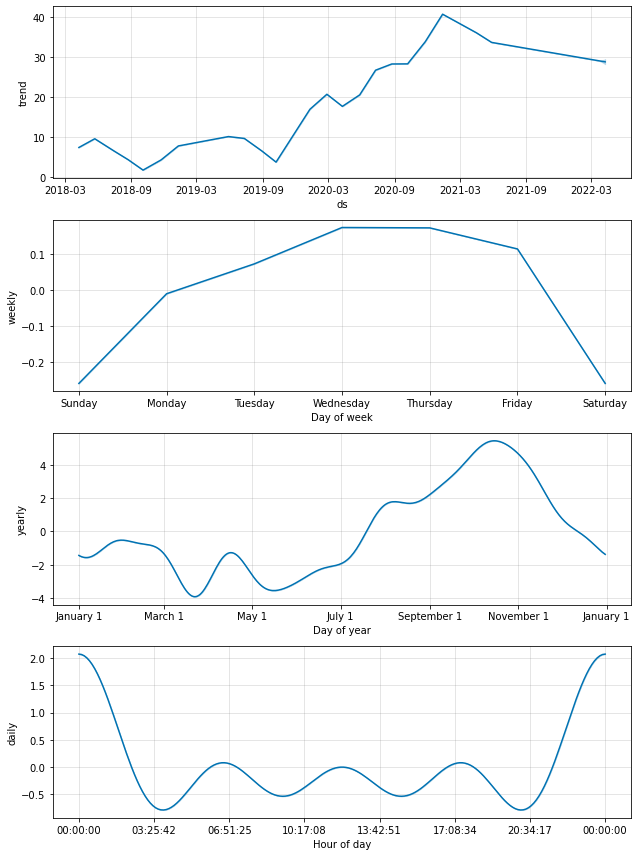

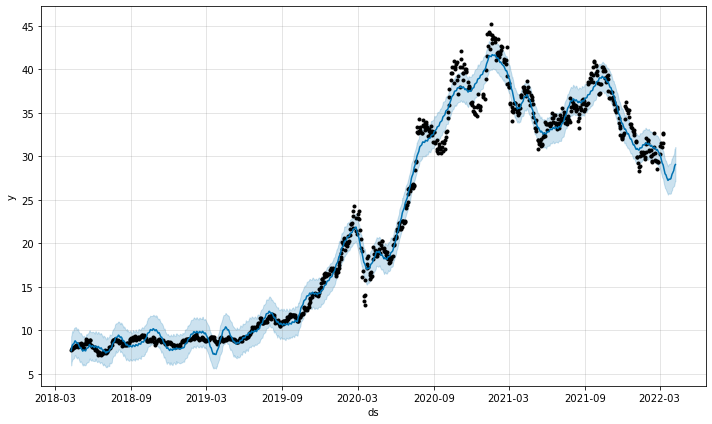

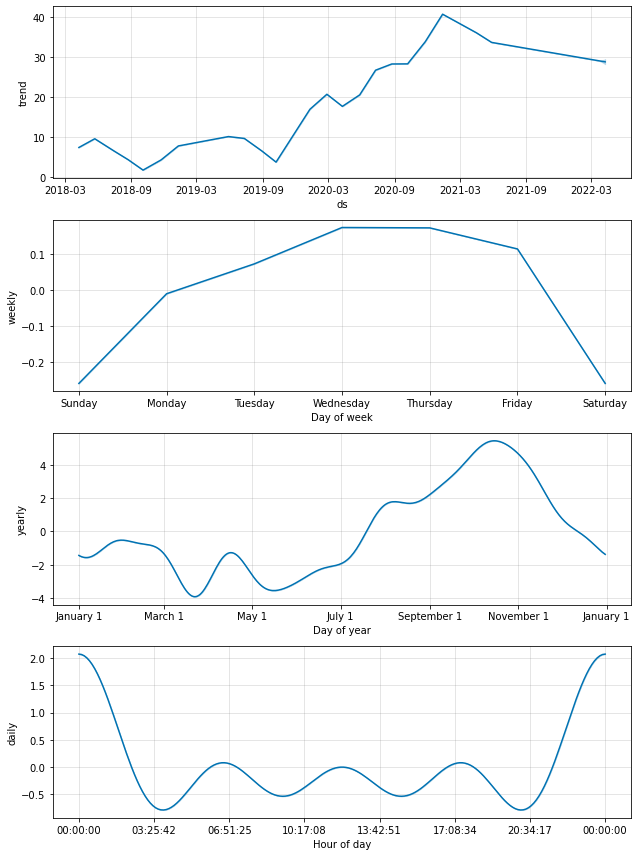

In [26]:
m.plot(forecast)
m.plot_components(forecast)

In [27]:
# execute cross validation

# reference
# https://facebook.github.io/prophet/docs/diagnostics.html#:~:text=Cross%20validation,up%20to%20that%20cutoff%20point.

df_cv = cross_validation(m, initial='720 days', period='30 days', horizon = '365 days')

# visualize data
print(df_cv.head())

# measure performance
df_p = performance_metrics(df_cv)
print(df_p.head())

INFO:prophet:Making 12 forecasts with cutoffs between 2020-04-13 00:00:00 and 2021-03-09 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

          ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2020-04-14  19.135055   18.428682   19.877007  19.026012 2020-04-13
1 2020-04-15  19.363715   18.608465   20.136944  18.585817 2020-04-13
2 2020-04-16  19.496088   18.726375   20.220969  18.590712 2020-04-13
3 2020-04-17  19.662894   18.926272   20.424193  18.810804 2020-04-13
4 2020-04-20  19.956730   19.213236   20.742556  19.123831 2020-04-13
  horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  30.773342  5.547373  4.185655  0.123106  0.089791  0.122517   
1 38 days  32.369356  5.689407  4.339553  0.127815  0.099098  0.126816   
2 39 days  33.928209  5.824793  4.472026  0.131767  0.101897  0.130542   
3 40 days  36.658537  6.054629  4.661768  0.136541  0.107323  0.135688   
4 41 days  38.993831  6.244504  4.842723  0.141447  0.118598  0.141048   

   coverage  
0  0.173423  
1  0.170186  
2  0.170796  
3  0.168497  
4  0.158784  


C:\Users\ldiogo\Anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

C:\Users\ldiogo\Anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



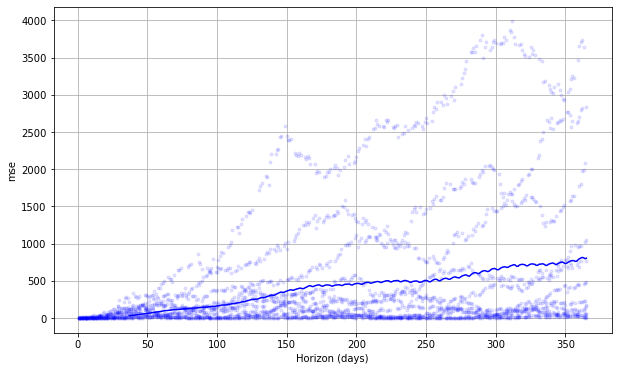

In [28]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')
